# Цель:
Неглубокие облака играют огромную роль в определении климата Земли, но их трудно распознать и классифицировать в климатических моделях. Классифицируя различные типы организации облаков, исследователи из Института Макса Планка надеются улучшить наше физическое понимание этих облаков, что, в свою очередь, поможет нам построить более совершенные климатические модели.

Существует множество способов организации облаков, но границы между различными формами организации нечеткие. Это затрудняет построение традиционных алгоритмов, основанных на правилах, для разделения облачных характеристик. Однако человеческий глаз отлично справляется с обнаружением особенностей - например, облаков, похожих на цветы.

В этом задании вам предстоит построить модель для классификации моделей организации облаков на спутниковых снимках. В случае успеха вы поможете ученым лучше понять, как облака будут определять наш будущий климат.


# Описание/Пошаговая инструкция выполнения домашнего задания:
- сформировать нейронную сверточную сеть;
- обучить сеть на представленных данных;
- оценить качество модели. В качестве критерия используйте Dice coefficient.
- датасет для обучения модели: https://www.kaggle.com/competitions/understanding_cloud_organization/data

# Критерии оценки:
- Обученная сеть;
- График обучения;
- Алгоритм обучения с условием раннего останова по метрике.

In [37]:
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import optuna
import torch


In [2]:
data_path = "./cloud/"

In [3]:
df = pd.read_csv(data_path + "train.csv")
df

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...
...,...,...
22179,ffd6680.jpg_Sugar,NaN
22180,ffea4f4.jpg_Fish,NaN
22181,ffea4f4.jpg_Flower,1194860 675 1196260 675 1197660 675 1199060 67...
22182,ffea4f4.jpg_Gravel,NaN


In [4]:
df[['image', 'label']] = df['Image_Label'].str.split('_', n=1, expand=True)
df

,Image_Label,EncodedPixels,image,label
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...,0011165.jpg,Fish
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...,0011165.jpg,Flower
2,0011165.jpg_Gravel,NaN,0011165.jpg,Gravel
3,0011165.jpg_Sugar,NaN,0011165.jpg,Sugar
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...,002be4f.jpg,Fish
...,...,...,...,...
22179,ffd6680.jpg_Sugar,NaN,ffd6680.jpg,Sugar
22180,ffea4f4.jpg_Fish,NaN,ffea4f4.jpg,Fish
22181,ffea4f4.jpg_Flower,1194860 675 1196260 675 1197660 675 1199060 67...,ffea4f4.jpg,Flower
22182,ffea4f4.jpg_Gravel,NaN,ffea4f4.jpg,Gravel


In [5]:
class_order = df.label.unique()
counts = df.groupby('label')['EncodedPixels'].count()
weights = (counts / counts.sum()).to_list()

In [6]:
df = df.pivot(index='image', columns='label', values='EncodedPixels').reindex(columns=class_order).reset_index().rename_axis(None, axis=1)

In [7]:
df.head(1)

,image,Fish,Flower,Gravel,Sugar
0,0011165.jpg,264918 937 266318 937 267718 937 269118 937 27...,1355565 1002 1356965 1002 1358365 1002 1359765...,NaN,NaN


In [8]:
def rle_decode(mask_rle, shape):
    """
    mask_rle: строка RLE "start length start length ..."
    shape: (H, W)
    return: np.ndarray (H, W) uint8 {0,1}
    """
    if mask_rle is None or (isinstance(mask_rle, float) and np.isnan(mask_rle)) or mask_rle == '':
        return np.zeros(shape, dtype=np.uint8)

    s = mask_rle.split()
    starts = np.asarray(s[0::2], dtype=np.int64)
    lengths = np.asarray(s[1::2], dtype=np.int64)

    starts -= 1  # RLE в соревновании 1-based
    ends = starts + lengths

    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape, order='F')


In [9]:
def show_imd_with_mask(img, mask):
    cmaps = ['Reds', 'Greens', 'Blues', 'Oranges']
    plt.imshow(img)
    if len(mask.shape) == 2:
        mask = np.expand_dims(mask, axis=0)
    for i in range(mask.shape[0]):
        plt.imshow(mask[i], cmap=cmaps[i], alpha=0.4)        
    plt.axis('off')
    plt.show()

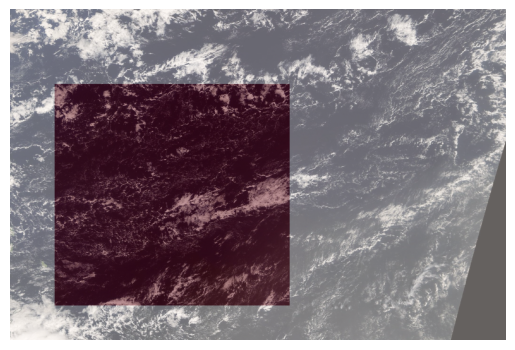

In [10]:
img_idx = 0
img = np.array(Image.open(data_path + "train_images/" + df['image'][30]))                
mask = rle_decode(df['Fish'][img_idx], shape=img.shape[:2] )    

show_imd_with_mask(img, mask)


# Датасет

In [11]:
class CloudDataset(Dataset):
    def __init__(self,  df, images_dir, class_order, transforms=None):
        self.df = df
        self.images_dir = images_dir
        self.class_order = class_order
        self.transforms = transforms
        self.len = df.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        image_id = self.df.iloc[idx, 0]
        img_path = f"{self.images_dir}/{image_id}"

        img = np.array(Image.open(img_path).convert("RGB"))
        H, W = img.shape[:2]

        masks = []
        row = self.df.iloc[idx]
        for cls in self.class_order:
            rle = row[cls]
            mask = rle_decode(rle, shape=(H, W))  
            masks.append(mask)

        mask = np.stack(masks, axis=0).astype(np.float32)  # (4, H, W)
        if self.transforms is not None:
            # Важно: трансформации должны применяться одинаково к img и mask
            aug = self.transforms(image=img, mask=mask.transpose(1, 2, 0))  # -> (H,W,4)
            img = aug["image"]   # (3,384,576) после ToTensorV2
            mask = aug["mask"].permute(2, 0, 1).float()  # обратно (4,384,576)


        return img , mask


In [12]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_tfms = A.Compose([
    A.Resize(height=384, width=576),

    # Геометрия
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
        shift_limit=0.05, scale_limit=0.10, rotate_limit=10,
        border_mode=0, p=0.7
    ),

    # Цвет/яркость (маску не трогает)
    A.RandomBrightnessContrast(p=0.5),

    # Нормализация (под ImageNet) + перевод в torch.Tensor
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                max_pixel_value=255.0),
    ToTensorV2(),
])  # порядок Normalize -> ToTensorV2 типовой для albumentations [web:552]

val_tfms = A.Compose([
    A.Resize(height=384, width=576),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                max_pixel_value=255.0),
    ToTensorV2(),
])  # без рандома [web:1011]



/Users/vadim/Code/OTUS/ML-Prof/.venv/lib/python3.12/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [13]:
from sklearn.model_selection import train_test_split
images_dir = data_path + "train_images/"
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
train_ds = CloudDataset(train_df, images_dir, class_order, transforms=train_tfms)
val_ds   = CloudDataset(val_df, images_dir, class_order, transforms=val_tfms)


# Модель

In [14]:
import torchvision
from torchvision.models import ResNet50_Weights
import torch.nn as nn

model = torchvision.models.segmentation.deeplabv3_resnet50(
    weights=None,
    weights_backbone=ResNet50_Weights.IMAGENET1K_V2,
    num_classes=4,
    aux_loss=False
)

class OutWrapper(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m = m
    def forward(self, x):
        return self.m(x)["out"]

model = OutWrapper(model)



# Функция потерь

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, bce_weight=0.5, threshold=0.5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.bce_weight = bce_weight
        self.threshold = threshold
    
    @classmethod
    def dice_score_from_logits(cls,logits, targets, eps=1e-7, threshold=0.5):
        probs = logits.sigmoid()
        preds = (probs > threshold).float()

        # (B,4,H,W) -> считаем по каналам, потом усредняем
        dims = (0, 2, 3)  # суммируем по batch+пикселям, оставляем class dim
        inter = (preds * targets).sum(dim=dims)
        denom = preds.sum(dim=dims) + targets.sum(dim=dims)
        dice_per_class = (2 * inter + eps) / (denom + eps)
        return dice_per_class.mean()
    
    def forward(self, logits, targets):
        bce = self.bce(logits, targets)
        dice_loss = 1 - self.dice_score_from_logits(logits, targets, threshold=self.threshold)
        return bce * self.bce_weight + dice_loss * (1 - self.bce_weight)
        
dice_bce_stop = DiceBCELoss()    

# Обучение

In [16]:
from tqdm import tqdm
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0

    for x, y in tqdm(loader):
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = dice_bce_stop(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    return total_loss / len(loader.dataset)

@torch.no_grad()
def validate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_dice = 0.0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = dice_bce_stop(logits, y)
        total_loss += loss.item() * x.size(0)

        total_dice += DiceBCELoss.dice_score_from_logits(logits, y) * x.size(0)

    return total_loss / len(loader.dataset), total_dice / len(loader.dataset)


In [17]:
best_dice = -1.0
patience = 5
bad_epochs = 0
n_epochs = 5
batch_size = 16

In [19]:
import os

ckpt_path = "best.pt"

    
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=False)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
if torch.cuda.is_available():
    device = "cuda" 
elif torch.mps.is_available(): 
    device = "mps" 
else:
    device = "cpu"

model.to(device)

if os.path.exists(ckpt_path):
    state_dict = torch.load(ckpt_path)  
    model.load_state_dict(state_dict)
    print(f"Loaded weights from {ckpt_path}")
    _, best_dice = validate(model, val_loader, device)
    print(f"best Dice: {best_dice:.4f} ")
else:
    print(f"No checkpoint at {ckpt_path}, training from scratch")


for epoch in range(1, n_epochs + 1):
    print(f"Epoch {epoch}")
    train_loss = train_one_epoch(model, train_loader, optimizer, device)
    val_loss, val_dice = validate(model, val_loader, device)
    print(f"train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, val dice: {val_dice:.4f}")
    if val_dice > best_dice:
        best_dice = val_dice
        bad_epochs = 0
        torch.save(model.state_dict(), ckpt_path)
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            break


Loaded weights from best.pt
best Dice: 0.5645 
Epoch 1


100%|██████████| 278/278 [09:37<00:00,  2.08s/it]


train loss: 0.2268, val loss: 0.3942, val dice: 0.5355
Epoch 2


100%|██████████| 278/278 [10:20<00:00,  2.23s/it]


train loss: 0.2114, val loss: 0.3837, val dice: 0.5612
Epoch 3


100%|██████████| 278/278 [10:22<00:00,  2.24s/it]


train loss: 0.1989, val loss: 0.3965, val dice: 0.5439
Epoch 4


100%|██████████| 278/278 [10:12<00:00,  2.20s/it]


train loss: 0.1911, val loss: 0.3901, val dice: 0.5547
Epoch 5


100%|██████████| 278/278 [10:14<00:00,  2.21s/it]


train loss: 0.1842, val loss: 0.3948, val dice: 0.5536


## Немного истории
- Epoch 10
  - train loss: 0.3479, val loss: 0.3808, val dice: 0.5134
  - Училась 111 мин
- Epoch 20
  - train loss: 0.2964, val loss: 0.3804, val dice: 0.5351
  - училась 114 мин
- Epoch 28
  - Вышла по раннему завершению.
  - Лучшие показатели.
    - train loss: 0.2640, val loss: 0.3621, val dice: 0.5633
  - Попробуем поменять LR на 5е-4 и продолжим

# Подбор порогов

In [ ]:
@torch.no_grad()
def collect_val_probs(model, val_loader, device):
    """
    Зачем:
      Нам нужны вероятности (после sigmoid) и истинные маски на val.
      Это позволит подбирать пороги очень быстро: мы больше не гоняем модель,
      а только порогуем numpy-массивы и считаем Dice.

    Возвращает:
      probs: (N, 4, H, W) float32, значения в [0, 1]
      masks: (N, 4, H, W) uint8/float, значения 0/1
    """
    model.eval()

    probs_list = []
    masks_list = []

    for x, y in val_loader:
        # x: (B,3,H,W), y: (B,4,H,W)
        x = x.to(device)

        # 1) forward -> logits
        logits = model(x)  # (B,4,H,W)

        # 2) logits -> probabilities
        probs = torch.sigmoid(logits)  # (B,4,H,W)

        # 3) перенос на CPU и конверсия в numpy
        probs_list.append(probs.cpu().numpy().astype(np.float32))
        masks_list.append(y.cpu().numpy())

    probs = np.concatenate(probs_list, axis=0)
    masks = np.concatenate(masks_list, axis=0)

    return probs, masks


In [ ]:
def score_thresholds(probs, masks, pixel_thresholds, min_pixels, eps=1e-7):
    """
    Что делаем:
      1) Для каждого класса c:
         - Бинаризуем вероятности: pred = probs[:,c] > pixel_thresholds[c]
      2) Боремся с шумом:
         - Считаем площадь предсказанной маски на КАЖДОМ изображении отдельно
         - Если площадь < min_pixels[c], считаем что класса нет -> зануляем маску
      3) Считаем Dice по классу на всём val (micro Dice)
      4) Усредняем Dice по 4 классам и возвращаем одно число (чем выше, тем лучше)

    Вход:
      probs: (N,4,H,W) float, значения в [0,1] (это sigmoid(logits))
      masks: (N,4,H,W) 0/1
      pixel_thresholds: array-like (4,)
      min_pixels: array-like (4,)  (например, [0, 500, 200, 800])
    """
    pixel_thresholds = np.asarray(pixel_thresholds, dtype=np.float32)
    min_pixels = np.asarray(min_pixels, dtype=np.int32)

    dices = []

    for c in range(4):
        # (A) Порог по пикселям -> бинарная маска
        pred = (probs[:, c] > pixel_thresholds[c])     # bool (N,H,W)
        targ = (masks[:, c] > 0.5)                     # bool (N,H,W) на всякий случай

        # (B) Площадь предсказания на каждом изображении (N,)
        area = pred.reshape(pred.shape[0], -1).sum(axis=1)

        # (C) Антишум: маленькие маски считаем ложными срабатываниями
        pred[area < min_pixels[c]] = False

        # (D) Micro Dice по всему val для класса c
        inter = np.logical_and(pred, targ).sum()
        denom = pred.sum() + targ.sum()
        dice_c = (2.0 * inter + eps) / (denom + eps)
        dices.append(dice_c)

    return float(np.mean(dices)), np.array(dices, dtype=np.float32)


In [ ]:
def make_objective(probs, masks):
    """
    Зачем:
      Optuna требует функцию objective(trial) -> float.
      Внутри objective мы:
        1) "сэмплируем" (предлагаем) 8 гиперпараметров: 4 порога + 4 min_pixels
        2) считаем качество (mean Dice) через score_thresholds
        3) возвращаем score (Optuna будет его максимизировать)
    """
    def objective(trial):
        # (1) Подбираем pixel threshold отдельно для каждого класса.
        pixel_thresholds = np.array([
            trial.suggest_float(f"pix_t_{c}", 0.01, 0.99)  
            for c in range(4)
        ], dtype=np.float32)

        # (2) Подбираем минимальную площадь маски (антишум) отдельно для каждого класса.
        min_pixels = np.array([
            trial.suggest_int(f"min_pix_{c}", 0, 8000)    
            for c in range(4)
        ], dtype=np.int32)

        # (3) Считаем метрику на val (по сохранённым probs/masks)
        mean_dice, dice_per_class = score_thresholds(
            probs, masks,
            pixel_thresholds=pixel_thresholds,
            min_pixels=min_pixels
        )

        trial.set_user_attr("dice_per_class", dice_per_class.tolist())

        return mean_dice

    return objective


In [ ]:
def run_threshold_search(probs, masks, n_trials=800, seed=42):
    """
    Что делаем:
      1) Строим objective(trial) на основе probs/masks
      2) Создаём Optuna study (maximize)
      3) Запускаем n_trials попыток
      4) Возвращаем лучшие пороги и лучший score

    Параметры:
      n_trials: чем больше, тем тщательнее (и дольше)
      seed: чтобы результаты были воспроизводимее
    """

    # 1) objective
    objective = make_objective(probs, masks)

    # 2) sampler — как выбирать новые значения параметров.
    sampler = optuna.samplers.TPESampler(seed=seed) 

    # 3) pruner — раннее отбрасывание плохих trial'ов.
    pruner = optuna.pruners.MedianPruner(n_startup_trials=50) 

    # 4) study
    study = optuna.create_study(
        direction="maximize",
        sampler=sampler,
        pruner=pruner,
    ) 

    # 5) optimize
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)  

    # 6) достаём лучшее
    best_params = study.best_params
    best_score = study.best_value

    best_pixel_thresholds = np.array([best_params[f"pix_t_{c}"] for c in range(4)], dtype=np.float32)
    best_min_pixels = np.array([best_params[f"min_pix_{c}"] for c in range(4)], dtype=np.int32)

    return best_pixel_thresholds, best_min_pixels, float(best_score), study


In [ ]:
@torch.no_grad()
def postprocess_logits_to_masks(
    logits,
    pixel_thresholds,
    min_pixels,
):
    """
    Вход:
      logits: torch.Tensor (B,4,H,W) - сырые выходы модели
      pixel_thresholds: array-like (4,) - порог по пикселям для каждого класса
      min_pixels: array-like (4,) - если площадь маски < min_pixels[c], маску зануляем

    Выход:
      masks: torch.Tensor (B,4,H,W) float32, значения 0/1
    """
    device = logits.device
    B, C, H, W = logits.shape
    assert C == 4, "Ожидается 4 канала классов"

    # 1) logits -> probabilities
    probs = torch.sigmoid(logits)  # (B,4,H,W)

    # 2) пороги переводим в тензоры на нужном device
    pix_t = torch.tensor(pixel_thresholds, device=device, dtype=probs.dtype).view(1, C, 1, 1)
    min_pix = torch.tensor(min_pixels, device=device, dtype=torch.long).view(1, C)

    # 3) порогование по пикселям (получаем bool)
    pred = probs > pix_t  # (B,4,H,W) bool

    # 4) считаем площадь маски по каждому изображению и классу
    area = pred.flatten(2).sum(dim=2)  # (B,4) long

    # 5) антишум: если площадь мала, зануляем маску целиком для этого (b,c)
    keep = area >= min_pix             # (B,4) bool
    pred = pred & keep.view(B, C, 1, 1)

    # 6) возвращаем 0/1 float (удобно для сохранения/метрик)
    return pred.float()


In [ ]:
probs, masks = collect_val_probs(model, val_loader, device)
print("Collected:", probs.shape, masks.shape)

mean_dice_05, dice_pc_05 = score_thresholds(
    probs, masks,
    pixel_thresholds=[0.5, 0.5, 0.5, 0.5],
    min_pixels=[0, 0, 0, 0],
)
print("Baseline (t=0.5, min_pix=0):", mean_dice_05, dice_pc_05)


best_pix_t, best_min_pix, best_dice, study = run_threshold_search(
    probs, masks,
    n_trials=800,
    seed=42
)

print("Best mean dice:", best_dice)
print("Best pixel thresholds:", best_pix_t)
print("Best min_pixels:", best_min_pix)

mean_dice_best, dice_pc_best = score_thresholds(
    probs, masks,
    pixel_thresholds=best_pix_t,
    min_pixels=best_min_pix,
)
print("Re-check best:", mean_dice_best, dice_pc_best)


x, y = next(iter(val_loader))
x = x.to(device)
with torch.no_grad():
    logits = model(x)  # (B,4,H,W)

pred_masks = postprocess_logits_to_masks(
    logits,
    pixel_thresholds=best_pix_t,
    min_pixels=best_min_pix
)
print("Pred masks:", pred_masks.shape, pred_masks.dtype)



In [30]:
# Повторил вывод, т.к. очистил предыдущую ячейку
print("Best mean dice:", best_dice)
print("Best pixel thresholds:", best_pix_t)
print("Best min_pixels:", best_min_pix)
print("Re-check best:", mean_dice_best, dice_pc_best)
print("Pred masks:", pred_masks.shape, pred_masks.dtype)

Best mean dice: 0.5827026580918914
Best pixel thresholds: [0.274348   0.2888893  0.30712134 0.33509588]
Best min_pixels: [6521 7882 6652 7247]
Re-check best: 0.5827026580918914 [0.51789373 0.667595   0.5484229  0.596899  ]
Pred masks: torch.Size([16, 4, 384, 576]) torch.float32


# Смотрим


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


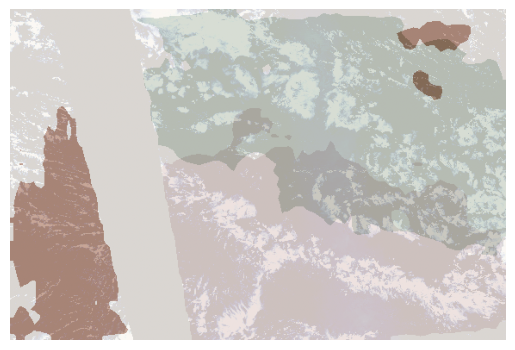

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6399999].


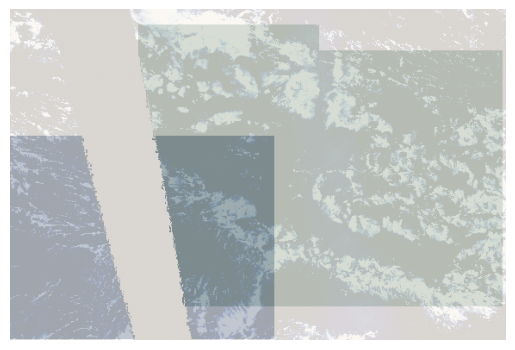

In [35]:
x, y = val_ds[10]
x = x.unsqueeze(0)                # (1,3,H,W)
x = x.to(device)

model.eval()
with torch.no_grad():
    logits = model(x)             # (1,4,H,W)

pred =  postprocess_logits_to_masks(logits, best_pix_t, best_min_pix)  # (4,H,W)


show_imd_with_mask(x[0].permute(1,2,0).cpu().numpy(), pred[0].cpu().numpy())
show_imd_with_mask(x[0].permute(1,2,0).cpu().numpy(), y.numpy())